Image Denoising, Extract images from video, Process images of a video

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Median Filter:
  PSNR: 25.5120, SSIM: 0.6372, MSE: 0.002811

Wavelet Denoising:
  PSNR: 25.6337, SSIM: 0.6848, MSE: 0.002733

Simulated Noise2Void:
  PSNR: 22.4415, SSIM: 0.6492, MSE: 0.005700



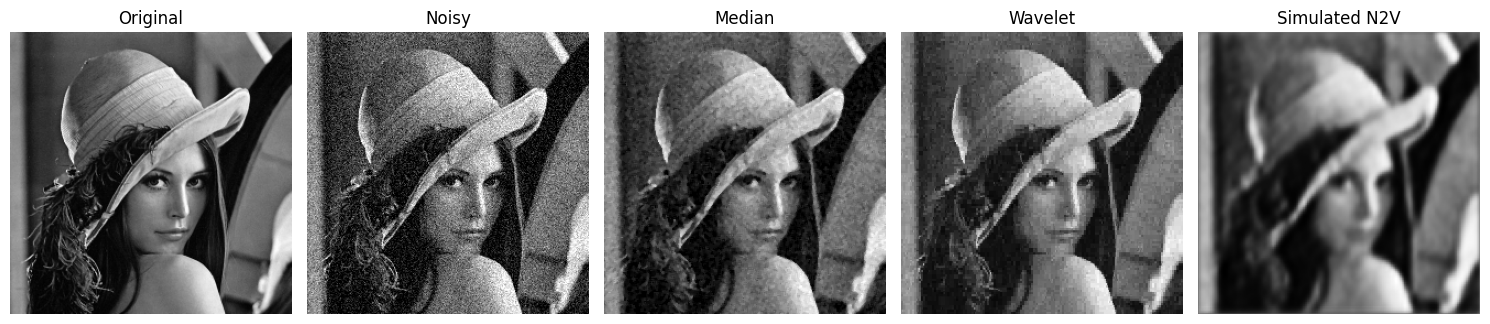

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, metrics, img_as_float
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# STEP 3: Load and Preprocess Image
image = cv2.imread('image1.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (256, 256))
image = img_as_float(image)

# Add synthetic Gaussian noise
noisy_image = image + 0.1 * np.random.normal(loc=0, scale=1, size=image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

# STEP 4: Denoising Techniques

## 1. Median Filter
median_denoised = cv2.medianBlur((noisy_image * 255).astype(np.uint8), 3) / 255.0

## 2. Wavelet Denoising
wavelet_denoised = restoration.denoise_wavelet(noisy_image, method='BayesShrink', mode='soft', rescale_sigma=True)

## 3. Simulated Noise2Void using Autoencoder
# Prepare data for training
X = noisy_image.reshape(1, 256, 256, 1)
y = image.reshape(1, 256, 256, 1)

# Build autoencoder
inp = Input(shape=(256, 256, 1))
x = Conv2D(64, (3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(inp, out)
autoencoder.compile(optimizer='adam', loss='mse')

# Train on single image (simulate Noise2Void)
autoencoder.fit(X, y, epochs=50, verbose=0)

# Predict denoised image
n2v_denoised = autoencoder.predict(X)[0,...,0]

# STEP 5: Evaluate
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def evaluate(original, denoised):
    psnr = peak_signal_noise_ratio(original, denoised, data_range=1.0)
    ssim = structural_similarity(original, denoised, data_range=1.0)
    mse = mean_squared_error(original, denoised)
    return psnr, ssim, mse


results = {
    "Median Filter": evaluate(image, median_denoised),
    "Wavelet Denoising": evaluate(image, wavelet_denoised),
    "Simulated Noise2Void": evaluate(image, n2v_denoised),
}

# Display metrics
for method, (psnr, ssim, mse) in results.items():
    print(f"{method}:\n  PSNR: {psnr:.4f}, SSIM: {ssim:.4f}, MSE: {mse:.6f}\n")

# STEP 6: Show Visual Comparison
titles = ['Original', 'Noisy', 'Median', 'Wavelet', 'Simulated N2V']
images = [image, noisy_image, median_denoised, wavelet_denoised, n2v_denoised]

plt.figure(figsize=(15, 6))
for i in range(len(images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Extract images from video:

In [3]:
import cv2
import os

# Step 1: Define path for the video
video_path = 'pedestrian.mp4'  # Update with your video file name if needed

# Step 2: Set up a folder to save the frames
output_folder = 'extracted_frames'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Step 3: Open the video using cv2.VideoCapture
cap = cv2.VideoCapture(video_path)

# Step 4: Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    frame_number = 0

    # Step 5: Loop through each frame of the video
    while True:
        ret, frame = cap.read()  # Read a frame from the video
        if not ret:
            break  # Stop if no more frames are available

        # Step 6: Save the frame as an image
        frame_filename = os.path.join(output_folder, f"frame_{frame_number:04d}.png")
        cv2.imwrite(frame_filename, frame)  # Save the frame

        # Step 7: Increment frame number
        frame_number += 1

    # Step 8: Release the video capture object
    cap.release()

print(f"Frames extracted and saved in folder '{output_folder}'.")


Frames extracted and saved in folder 'extracted_frames'.


Process images of a video:

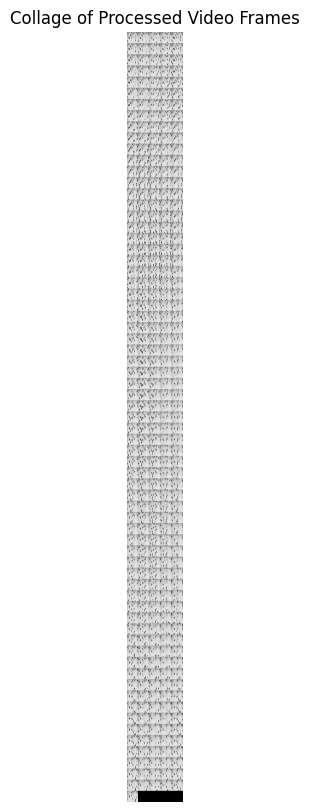

Processed video saved as 'processed_video.mp4'


In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Step 1: Load the video
video_path = 'pedestrian.mp4'  # Replace with your video file
cap = cv2.VideoCapture(video_path)

# Step 2: Create output folder for frames
output_folder = 'processed_frames'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Step 3: Prepare to store processed frames
processed_frames = []

# Step 4: Loop through each frame of the video and apply image processing techniques
frame_number = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Stop when there are no more frames

    # Convert frame to grayscale (required for some operations)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1. Adaptive Thresholding
    adaptive_thresh = cv2.adaptiveThreshold(
        gray_frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    # 2. Gaussian Smoothing
    gaussian_blur = cv2.GaussianBlur(frame, (5, 5), 0)

    # 3. Canny Edge Detection
    canny_edges = cv2.Canny(gray_frame, 100, 200)

    # 4. Bitwise NOT
    bitwise_not = cv2.bitwise_not(frame)

    # Save processed frames to the folder
    adaptive_thresh_filename = os.path.join(output_folder, f'adaptive_thresh_{frame_number:04d}.png')
    gaussian_blur_filename = os.path.join(output_folder, f'gaussian_blur_{frame_number:04d}.png')
    canny_edges_filename = os.path.join(output_folder, f'canny_edges_{frame_number:04d}.png')
    bitwise_not_filename = os.path.join(output_folder, f'bitwise_not_{frame_number:04d}.png')

    cv2.imwrite(adaptive_thresh_filename, adaptive_thresh)
    cv2.imwrite(gaussian_blur_filename, gaussian_blur)
    cv2.imwrite(canny_edges_filename, canny_edges)
    cv2.imwrite(bitwise_not_filename, bitwise_not)

    # Store the processed frames for video creation
    processed_frames.append(gaussian_blur)  # You can change this to use other processed images for the final video

    frame_number += 1

# Step 5: Release the video capture object
cap.release()

# Step 6: Create a collage of the processed frames
collage_width = 5  # Adjust width of the collage
collage_height = int(np.ceil(len(processed_frames) / collage_width))
collage = np.zeros((collage_height * 256, collage_width * 256, 3), dtype=np.uint8)

for i, frame in enumerate(processed_frames):
    row = i // collage_width
    col = i % collage_width
    collage[row * 256:(row + 1) * 256, col * 256:(col + 1) * 256] = cv2.resize(frame, (256, 256))

# Step 7: Display the collage
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Collage of Processed Video Frames')
plt.show()

# Step 8: Create a video from the processed frames
output_video_path = 'processed_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (256, 256))  # Adjust frame size as needed

# Write the processed frames to the new video
for frame in processed_frames:
    resized_frame = cv2.resize(frame, (256, 256))  # Resize the frame to match the video size
    out.write(resized_frame)

# Step 9: Release the video writer
out.release()

print(f"Processed video saved as '{output_video_path}'")


Crowd Analysis (YOLOv4)

In [ ]:
# Install necessary libraries
!pip install opencv-python-headless
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install pillow

# Clone the YOLOv4 repository from GitHub
!git clone https://github.com/AlexeyAB/darknet.git

# Navigate into the darknet folder and compile Darknet
%cd darknet
!make

# Download YOLOv4 pre-trained weights
!wget https://pjreddie.com/media/files/yolov4.weights

# Now let's load the YOLOv4 model and perform object detection on video
import cv2
import numpy as np

# Load YOLOv4 configuration and weights
net = cv2.dnn.readNet("yolov4.weights", "cfg/yolov4.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i-1] for i in net.getUnconnectedOutLayers()]

# Load the video or live stream (replace with the appropriate video source)
cap = cv2.VideoCapture('pedestrian.mp4')  # You can replace with webcam or another video file

# Create a VideoWriter to save the output video
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (640, 480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame for YOLO input
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)

    # Run the forward pass to get predictions
    outs = net.forward(output_layers)

    # Post-process YOLO outputs (bounding boxes, confidence scores, etc.)
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Threshold for object detection
                center_x = int(detection[0] * frame.shape[1])
                center_y = int(detection[1] * frame.shape[0])
                w = int(detection[2] * frame.shape[1])
                h = int(detection[3] * frame.shape[0])

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maxima suppression to remove redundant overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw the bounding boxes and labels on the image
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = str(class_ids[i])
        confidence = confidences[i]

        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f'{label} {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the frame with detections
    cv2.imshow('Crowd Monitoring - YOLOv4', frame)

    # Write the frame to the output video
    out.write(frame)

    # Break the loop with 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer
cap.release()
out.release()

# Destroy all OpenCV windows
cv2.destroyAllWindows()
